# SRules

# Statics

In [1]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics


## Load Dataset

In [2]:

from SRules.Tests.Utils.DatasetUtils import read_dataset

filename = "divorce"
X, y, dataset, target_value_name, pandas_dataset = read_dataset(filename, f'../data/{filename}.csv')

pandas_dataset.head()

,Atr1_0,Atr1_1,Atr1_2,Atr1_3,Atr1_4,Atr2_0,Atr2_1,Atr2_2,Atr2_3,Atr2_4,...,Atr53_1,Atr53_2,Atr53_3,Atr53_4,Atr54_0,Atr54_1,Atr54_2,Atr54_3,Atr54_4,Class
0,False,False,True,False,False,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,True
1,False,False,False,False,True,False,False,False,False,True,...,False,True,False,False,False,False,True,False,False,True
2,False,False,True,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,True
3,False,False,False,True,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,True
4,False,False,True,False,False,False,False,True,False,False,...,True,False,False,False,True,False,False,False,False,True


In [3]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.1, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(dataset['feature_names']) + [target_value_name])
print('Sizes (without target):')
print(f'Original size {dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')
print(f'encoded_train_pandas_dataset size {encoded_train_pandas_dataset.shape}')
print(f'encoded_test_pandas_dataset size {encoded_test_pandas_dataset.shape}')

Sizes (without target):
Original size (170, 270)
Train size (153, 270)
Test size (17, 270)
encoded_train_pandas_dataset size (153, 271)
encoded_test_pandas_dataset size (17, 271)


## Define Random Forest

In [4]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score
from lightgbm import LGBMClassifier

# Define scorer
ensemble = RandomForestClassifier()
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## SRules

 ----> SHAP - EXPLAINER
 ----> SHAP - VALUES


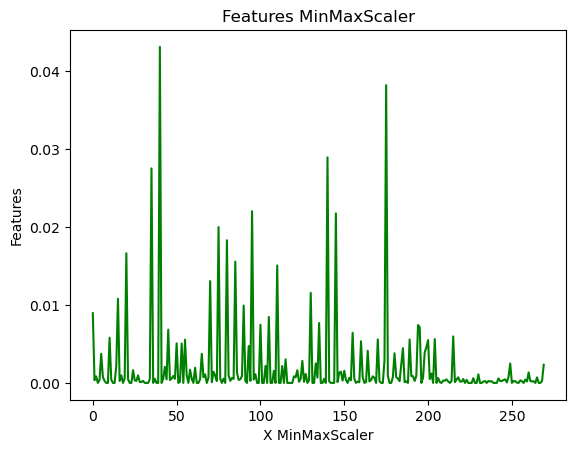

 ----> SHAP - EXPLAINER
 ----> SHAP - VALUES


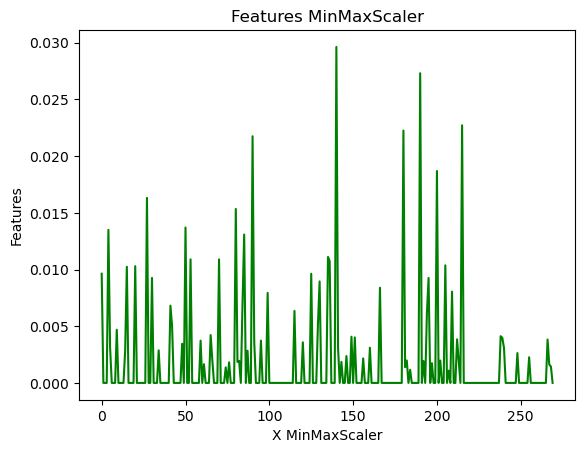

Elapsed TOTAL TIME: 7.895 seconds


In [5]:
from SRules.SRules import SRules

import time
start_time = time.time()
rules = SRules(
                feature_names=dataset.feature_names,
                target_value_name = dataset.target_names,
                display_features = False,
                display_logs = False,
                recursive=True,
                p_significance = 0.99,
                minImp = 0.01,
                min_accuracy_coefficient = 0.95,
                minInsNode = 5
            )
# Fit model
rules.fit(
    method=ensemble,
    X_train=X_train,
    y_train=y_train,
    original_dataset=encoded_train_pandas_dataset,
            use_shap=True,
            use_lime=False)

elapsed_time = time.time() - start_time
print(f"Elapsed TOTAL TIME: {elapsed_time:.3f} seconds")

# Print Model

In [6]:
print(rules)

> ++++++++++++++++++++++++++++
> SRules --  Number of Rules: 2
> SRules --  Number of Minimal Rules: 2
> ++++++++++++++++++++++++++++
> ------MINIMAL RULES--------
 ** Accuracy: 1.0
 ** Atr9_0 == False  &  Atr36_0 == False --> True
> ------------------------------
 ** Accuracy: 0.9726027397260274
 ** Atr9_0 == True --> False
> ------------------------------
> ------COMPLETE RULES--------
 ** Accuracy: 1.0
 ** Atr9_0 == False  &  Atr36_0 == False --> True
> ------------------------------
 ** Accuracy: 0.9726027397260274
 ** Atr9_0 == True --> False
> ------------------------------


# Predict

In [7]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test, sorting_method="target_accuracy")

In [8]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
ensemble_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF F1-score:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_F1 = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules F1-score:',str("{:.2f}".format(100*rules_F1))+'%')
rules_roc_auc = metrics.roc_auc_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules roc_auc_score:',str("{:.2f}".format(100*rules_roc_auc))+'%')


DATASET TEST: 17
DATASET TEST categorizable: 17
Cobertura: 100.00%
RF accuracy: 100.00%
RF F1-score: 100.00%
Rules Accuracy: 94.12%
Rules F1-score: 92.31%
Rules roc_auc_score: 92.86%


# SHAP explainer

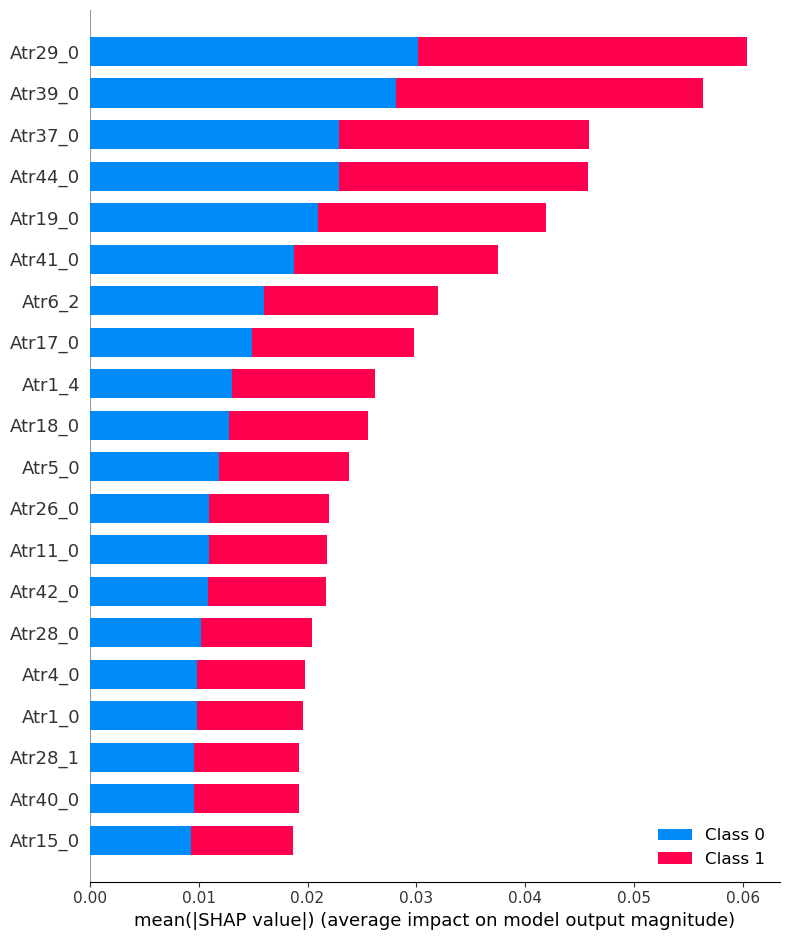

In [9]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names)


In [10]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [11]:
# Evaluate SHAP values
shap_values = explainer(X_test)
print_feature_importances_shap_values(shap_values,dataset.feature_names)

Atr29_0 -> 0.0302 (softmax = 0.0038)
Atr39_0 -> 0.0282 (softmax = 0.0038)
Atr37_0 -> 0.0229 (softmax = 0.0038)
Atr44_0 -> 0.0229 (softmax = 0.0038)
Atr19_0 -> 0.0210 (softmax = 0.0038)
Atr41_0 -> 0.0187 (softmax = 0.0038)
Atr6_2 -> 0.0160 (softmax = 0.0038)
Atr17_0 -> 0.0149 (softmax = 0.0038)
Atr1_4 -> 0.0131 (softmax = 0.0037)
Atr18_0 -> 0.0128 (softmax = 0.0037)
Atr5_0 -> 0.0119 (softmax = 0.0037)
Atr26_0 -> 0.0110 (softmax = 0.0037)
Atr11_0 -> 0.0109 (softmax = 0.0037)
Atr42_0 -> 0.0109 (softmax = 0.0037)
Atr28_0 -> 0.0102 (softmax = 0.0037)
Atr4_0 -> 0.0099 (softmax = 0.0037)
Atr1_0 -> 0.0098 (softmax = 0.0037)
Atr40_0 -> 0.0096 (softmax = 0.0037)
Atr28_1 -> 0.0096 (softmax = 0.0037)
Atr15_0 -> 0.0093 (softmax = 0.0037)
Atr34_1 -> 0.0087 (softmax = 0.0037)
Atr7_0 -> 0.0086 (softmax = 0.0037)
Atr27_0 -> 0.0083 (softmax = 0.0037)
Atr20_4 -> 0.0082 (softmax = 0.0037)
Atr9_1 -> 0.0080 (softmax = 0.0037)
Atr42_4 -> 0.0079 (softmax = 0.0037)
Atr39_4 -> 0.0072 (softmax = 0.0037)
Atr17_4 

In [12]:
shap.plots.bar(shap_values)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
shap.summary_plot(shap_values)


In [ ]:
shap.summary_plot(shap_values, plot_type='violin')